# Understanding the Image Class: Data Components and Accessors

This tutorial provides a comprehensive guide to the PhenoTypic `Image` class architecture, focusing on its main data components and how they interact with detection and analysis modules.

## Learning Objectives

By the end of this tutorial, you will understand:
- The Image class hierarchy and accessor pattern
- The six main data components: `rgb`, `gray`, `enh_gray`, `objmask`, `objmap`, and `metadata`
- How these components interact during image processing workflows
- When and how to use each component in your analysis


In [30]:
# Import required libraries
import phenotypic as pht
import numpy as np
import matplotlib.pyplot as plt


## 2. Loading an Image and Basic Properties

Let's start by loading a sample plate image from the built-in dataset. We'll use an image of bacterial colonies growing on agar media.


In [31]:
# Load a sample plate image (12 hours of growth)
image = pht.data.load_colony(mode='Image')

# Display basic properties
print(f"Image name: {image.name}")
print(f"Image shape: {image.shape}")
print(f"Bit depth: {image.bit_depth}")
print(f"Data type: {type(image)}")


Image name: later_colony
Image shape: (200, 162, 3)
Bit depth: 8
Data type: <class 'phenotypic.core._image.Image'>


(<Figure size 800x600 with 1 Axes>, <Axes: >)

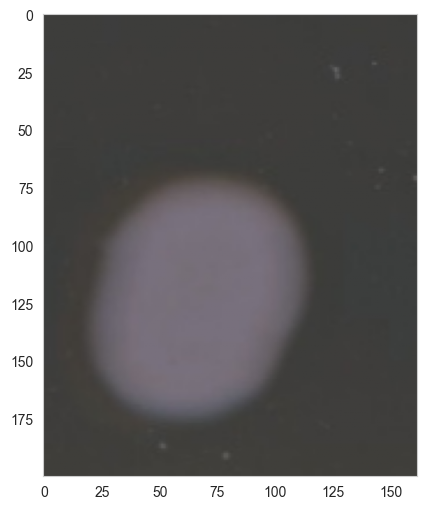

In [32]:
# Visualize the original image
image.show()

`Image.show()` will show the original input (either rgb or grayscale)

## 3. RGB Component: Multichannel Color Data

The **`rgb`** accessor provides access to the multichannel RGB representation of the image.

### Key Characteristics:
- **Data type**: uint8 (for 8-bit) or uint16 (for 16-bit images)
- **Shape**: `(height, width, 3)` - three channels for Red, Green, Blue
- **Access pattern**: Use bracket notation `image.rgb[:]` to get the array
- **Automatically set**: When loading a color image
- **Empty for grayscale**: If you load a 2D array, RGB remains empty


In [33]:
# Access the RGB data
rgb_data = image.rgb[:]

print(f"RGB shape: {rgb_data.shape}")
print(f"RGB dtype: {rgb_data.dtype}")
print(f"RGB value range: [{rgb_data.min()}, {rgb_data.max()}]")
print(f"\nIs RGB empty? {image.rgb.isempty()}")


RGB shape: (200, 162, 3)
RGB dtype: uint8
RGB value range: [55, 127]

Is RGB empty? False


(<Figure size 800x600 with 1 Axes>, <Axes: >)

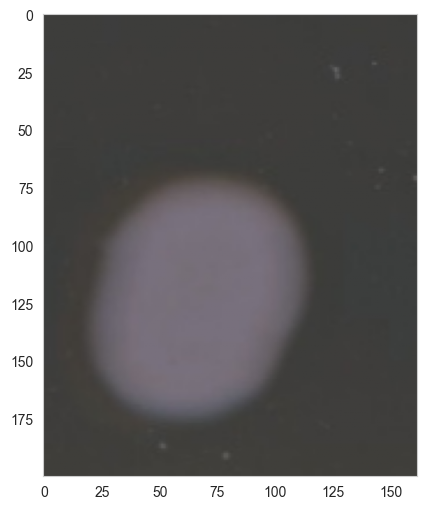

In [34]:
image.rgb.show()


## 4. Gray Component: Grayscale Representation

The **`gray`** accessor provides the grayscale representation of the image using weighted luminance conversion.

### Key Characteristics:
- **Data type**: float32 with values in [0, 1] range
- **Shape**: `(height, width)` - single channel
- **Conversion**: Automatically created from RGB using `skimage.color.rgb2gray`
- **Weighted formula**: `0.2125*R + 0.7154*G + 0.0721*B` (ITU-R BT.709)
- **Read-only**: Changes to gray won't modify RGB (use `enh_gray` for modifications)
- **Always present**: Even for grayscale-loaded images

The grayscale information is also the intensity information. Certain corrections like flat-field operate on this layer, but don't affect the RGB information. Thus, we keep it loaded in memory.

In [35]:
# Access the grayscale data
gray_data = image.gray[:]

print(f"Gray shape: {image.gray.shape}")
print(f"Gray dtype: {image.gray.dtype}")
print(f"Gray value range: [{gray_data.min():.4f}, {gray_data.max():.4f}]")
print(f"\nIs gray empty? {image.gray.isempty()}")


Gray shape: (200, 162)
Gray dtype: float64
Gray value range: [0.2269, 0.4574]

Is gray empty? False



💡 Note: The grayscale conversion preserves perceptual brightness better than simple averaging.


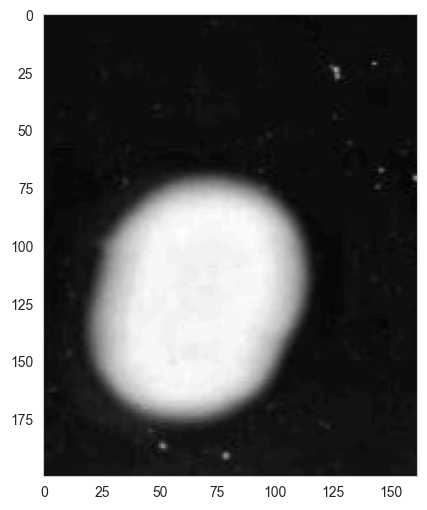

In [36]:
# Visualize grayscale conversion
image.gray.show()
print("\n💡 Note: The grayscale conversion preserves perceptual brightness better than simple averaging.")


## 5. Enhanced Gray Component: Mutable Processing Copy

The **`enh_gray`** accessor provides a mutable copy of the grayscale image for preprocessing and enhancement.

### Key Characteristics:
- **Data type**: float32 with values in [0, 1] range
- **Shape**: `(height, width)` - single channel
- **Initialization**: Starts as an exact copy of `gray`
- **Mutable**: Can be modified without affecting the original `gray`
- **Primary use**: Detection algorithms process `enh_gray`, preserving original data
- **Workflow**: Apply enhancement operations → Detector uses `enh_gray` → Original stays intact

Many traditional computer vision operations operate on the grayscale matrix for calculations. Thus, `Image.enh_gray.histogram()` is a powerful tool for deciding what operations our images needs to successfuly process. PhenoTypic uses a a two-path strategy for measurement and detection. Many operations that improve object detection affect the data integrity of the original grayscale which is used for intensity measurements. Thus, we incorporate the `enh_gray` matrix which is a copy of the original grayscale matrix used for operations that enhance detection. Operations for enhancing detection can be found in `phenotypic.enhace`.


In [37]:
# Access enhanced grayscale data
enh_gray_data = image.enh_gray[:]

print(f"Enhanced gray shape: {enh_gray_data.shape}")
print(f"Enhanced gray dtype: {enh_gray_data.dtype}")
print(f"Enhanced gray value range: [{enh_gray_data.min():.4f}, {enh_gray_data.max():.4f}]")

# Check if enh_gray starts as a copy of gray
print(f"\nAre gray and enh_gray initially equal? {np.allclose(gray_data, enh_gray_data)}")
print(f"Are they the same object? {np.shares_memory(gray_data, enh_gray_data)}")


Enhanced gray shape: (200, 162)
Enhanced gray dtype: float64
Enhanced gray value range: [0.2269, 0.4574]

Are gray and enh_gray initially equal? True
Are they the same object? False



💡 Note: Enhancement operations can be applied to enh_gray without affecting the original gray data.


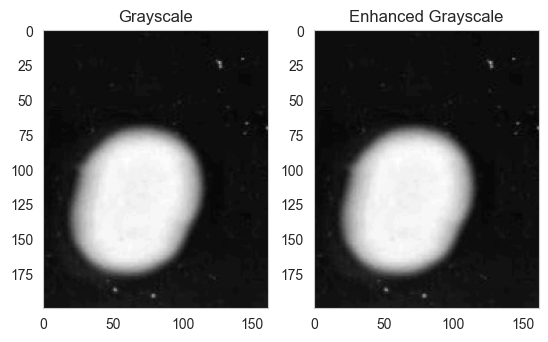

In [38]:
fig, axes = plt.subplots(ncols=2)
image.gray.show(ax=axes[0], title='Grayscale')
image.enh_gray.show(ax=axes[1], title='Enhanced Grayscale')

print("\n💡 Note: Enhancement operations can be applied to enh_gray without affecting the original gray data.")



💡 Note: Enhancement operations can be applied to enh_gray without affecting the original gray data.


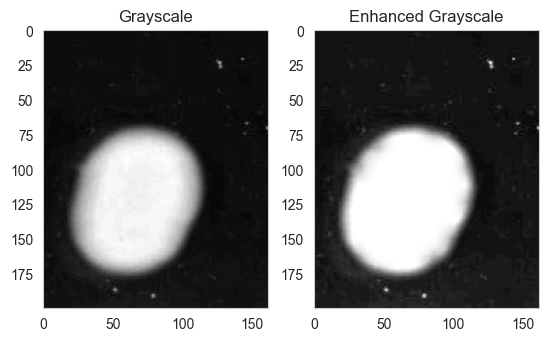

In [39]:
pht.enhance.CLAHE().apply(image, inplace=True)

fig, axes = plt.subplots(ncols=2)
image.gray.show(ax=axes[0], title='Grayscale')
image.enh_gray.show(ax=axes[1], title='Enhanced Grayscale')

print("\n💡 Note: Enhancement operations can be applied to enh_gray without affecting the original gray data.")


## 6. Object Mask and Object Map: Detection Results

The **`objmask`** and **`objmap`** accessors store the results of object detection algorithms. Let's apply the `OtsuDetector` to see them in action.

### OtsuDetector Workflow:
1. Reads `enh_gray` data
2. Calculates optimal threshold using Otsu's method
3. Creates binary mask and stores in `objmask`
4. Labels connected regions and stores in `objmap`


In [40]:
# Apply OtsuDetector to detect colonies
detector = pht.detect.OtsuDetector(ignore_zeros=True, ignore_borders=True)
detector.apply(image, inplace=True)

print("✅ Detection complete!")
print(f"Number of detected objects: {image.num_objects}")


✅ Detection complete!
Number of detected objects: 0


### 6.1 Object Mask: Binary Representation

The **`objmask`** is a binary mask showing which pixels belong to detected objects.

### Key Characteristics:
- **Values**: 0 (background) and 1 (object pixels)
- **Shape**: `(height, width)` - matches image dimensions
- **Storage**: Backed by sparse CSC matrix for memory efficiency
- **Mutable**: Can be modified (triggers automatic objmap relabeling)
- **Set by**: Detection algorithms (Otsu, Watershed, etc.)


In [41]:
# Access object mask
objmask_data = image.objmask[:]

print(f"Object mask shape: {objmask_data.shape}")
print(f"Object mask dtype: {objmask_data.dtype}")
print(f"Unique values: {np.unique(objmask_data)}")
print(f"Number of object pixels: {np.sum(objmask_data)}")
print(f"Number of background pixels: {np.sum(objmask_data == 0)}")
print(f"Percentage of image covered by objects: {100*np.sum(objmask_data)/objmask_data.size:.2f}%")


Object mask shape: (200, 162)
Object mask dtype: int64
Unique values: [0]
Number of object pixels: 0
Number of background pixels: 32400
Percentage of image covered by objects: 0.00%



💡 Note: The binary mask shows all detected object pixels without distinguishing individual objects.


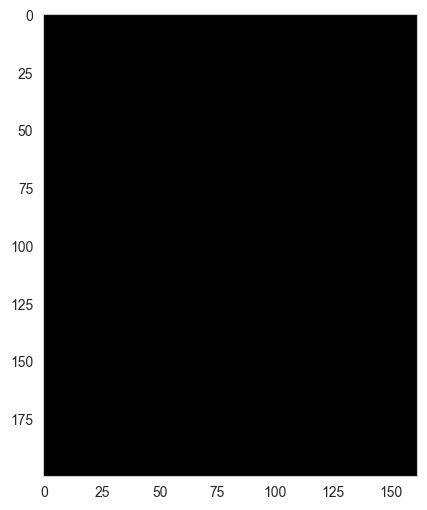

In [42]:
# Visualize the object mask
image.objmask.show()

print("\n💡 Note: The binary mask shows all detected object pixels without distinguishing individual objects.")


### 6.2 Object Map: Labeled Regions

The **`objmap`** assigns a unique integer ID to each connected region in the object mask.

### Key Characteristics:
- **Values**: 0 (background) and unique integers for each object (1, 2, 3, ...)
- **Shape**: `(height, width)` - matches image dimensions
- **Storage**: Sparse CSC matrix (shared backend with objmask)
- **Automatic labeling**: Created/updated when objmask changes
- **Used for**: Individual object analysis, measurements, slicing


In [43]:
# Access object map
objmap_data = image.objmap[:]

print(f"Object map shape: {objmap_data.shape}")
print(f"Object map dtype: {objmap_data.dtype}")
print(f"Number of unique objects: {len(np.unique(objmap_data)) - 1}")
print(f"Object IDs range: {objmap_data[objmap_data > 0].min()} to {objmap_data.max()}")
print(f"\nFirst 10 object IDs: {sorted(np.unique(objmap_data[objmap_data > 0]))[:10]}")


Object map shape: (200, 162)
Object map dtype: uint16
Number of unique objects: 0


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
# Visualize the labeled object map
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Object mask (binary)
axes[0].imshow(objmask_data, cmap='binary')
axes[0].set_title(f'Object Mask\n(Binary: {image.num_objects} objects)', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Object map (labeled)
axes[1].imshow(objmap_data, cmap='nipy_spectral')
axes[1].set_title('Object Map\n(Each color = unique object)', fontsize=12, fontweight='bold')
axes[1].axis('off')

# Overlay on original
axes[2].imshow(rgb_data)
# Create a masked array to show only objects
masked_objmap = np.ma.masked_where(objmap_data == 0, objmap_data)
axes[2].imshow(masked_objmap, cmap='nipy_spectral', alpha=0.5, interpolation='none')
axes[2].set_title('Labeled Objects Overlay', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Note: Each color in the object map represents a distinct detected colony.")


### Relationship Between objmask and objmap

The objmask and objmap are tightly coupled:
- **Shared backend**: Both use the same sparse CSC matrix storage
- **objmask → objmap**: Binary mask shows "where objects are"
- **objmap → objmask**: Labeled map shows "which object each pixel belongs to"
- **Automatic sync**: Modifying objmask triggers relabeling of objmap


In [ ]:
# Demonstrate the relationship
print("Relationship verification:")
print(f"objmask non-zero pixels: {np.count_nonzero(objmask_data)}")
print(f"objmap non-zero pixels: {np.count_nonzero(objmap_data)}")
print(f"Are non-zero locations identical? {np.all((objmask_data > 0) == (objmap_data > 0))}")

print(f"\nobjmask values: {np.unique(objmask_data)}")
print(f"objmap values: {len(np.unique(objmap_data))} unique (0 + {image.num_objects} objects)")


## 7. Metadata: Image Information Storage

The **`metadata`** accessor provides a three-tier system for storing image information.

### Three-Tier System:

1. **Private**: Internal system use only
   - UUID for unique identification
   - Not directly modifiable by users

2. **Protected**: System-managed metadata
   - `image_name`: Image identifier
   - `bit_depth`: 8 or 16 bit
   - `image_type`: BASE, OBJECT, or GRID
   - Can be read but modification is restricted

3. **Public**: User-modifiable metadata
   - Custom key-value pairs
   - Experimental conditions, timestamps, etc.
   - Fully modifiable by users


In [ ]:
# Access metadata
print("="*50)
print("METADATA CONTENTS")
print("="*50)

print("\n" + "-"*50)
print("Key metadata values:")
print("-"*50)
print(f"Name: {image.metadata['image_name']}")
print(f"Bit depth: {image.metadata['bit_depth']}")
print(f"Image type: {image.metadata['image_type']}")

image.metadata.table()

In [29]:
# Add custom metadata (public tier)
image.metadata['experiment_id'] = 'EXP_001'
image.metadata['growth_time_hours'] = 12
image.metadata['strain'] = 'Kluveromyces Marxianus'
image.metadata['temperature_celsius'] = 37.0
image.metadata['media_type'] = 'LB Agar'

image.metadata.table()

AttributeError: 'MetadataAccessor' object has no attribute 'table'

## 8. Practical Tips and Best Practices

### When to Use Each Component

| Component | Use When You Need To... |
|-----------|------------------------|
| **rgb** | Access color information, display full-color images, analyze individual color channels |
| **gray** | Work with intensity data, maintain original data integrity, perform measurements |
| **enh_gray** | Apply preprocessing, test enhancement algorithms, prepare for detection |
| **objmask** | Work with binary masks, perform morphological operations, modify detection results |
| **objmap** | Analyze individual objects, measure per-object properties, extract specific colonies |
| **metadata** | Store experimental context, track processing parameters, organize datasets |

### Accessor Pattern Benefits

1. **Consistent Interface**: All accessors use bracket notation `[:]`
2. **Data Integrity**: Read-only accessors prevent accidental modifications
3. **Automatic Sync**: Changes to objmask automatically update objmap
4. **Memory Efficiency**: Sparse storage for object maps saves memory
5. **Type Safety**: Accessors enforce correct data types

### Read-Only vs Mutable Components

**Read-Only** (viewing via `[:]` returns non-writable views):
- `rgb`: Preserve color data integrity
- `gray`: Maintain original grayscale reference

**Mutable** (can be modified in-place):
- `enh_gray`: Designed for preprocessing
- `objmask`: Can be refined post-detection
- `objmap`: Automatically updates with objmask
- `metadata`: Fully modifiable for custom data

### Integration with Other PhenoTypic Modules

**Detection** (`phenotypic.detect`):
```python
from phenotypic.detect import OtsuDetector, WatershedDetector
detector = OtsuDetector()
detector.apply(image)  # Populates objmask and objmap
```

**Enhancement** (`phenotypic.enhance`):
```python
from phenotypic.enhance import CLAHE, GaussianBlur
enhancer = CLAHE()
enhancer.apply(image)  # Modifies enh_gray
```

**Refine** (`phenotypic.refine`):
```python
from phenotypic.refine import BorderObjectRemover
refiner = BorderObjectRemover()
results = refiner.apply(image)  # uses objmask and objmap and cleans the detection results
```

**Measurement** (`phenotypic.measure`):
```python
from phenotypic.measure import MeasureSize
measurer = MeasureSize()
results = measurer.apply(image)  # Uses objmap for per-object analysis
```


**Analysis** (`phenotypic.analysis`):
```python
# Access individual objects using objmap labels
for obj in image.objects:
    print(f"Object {obj.label}: Area = {obj.area}")
```